In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from sqlalchemy import create_engine
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
import h5py
from tensorflow import keras
import dask.dataframe as dd
import os
from tqdm import tqdm
from tensorflow.python.client import device_lib

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Justin Chow Taxi Fare Preiction Model
# https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

#print ("TensorFlow version: " + tf.__version__)
#print(device_lib.list_local_devices())

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

TRAIN_PATH = '/Users/mchow3/Desktop/csula/4661/Project/train.csv'
TEST_PATH = '/Users/mchow3/Desktop/csula/4661/Project/test.csv'

with open(TRAIN_PATH) as file:
    n_rows = len(file.readlines())

print (f'Exact number of rows: {n_rows}')

Exact number of rows: 55423857


In [34]:
df_tmp = pd.read_csv(TRAIN_PATH, nrows=5)
df_tmp.head()
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
key                  5 non-null object
fare_amount          5 non-null float64
pickup_datetime      5 non-null object
pickup_longitude     5 non-null float64
pickup_latitude      5 non-null float64
dropoff_longitude    5 non-null float64
dropoff_latitude     5 non-null float64
passenger_count      5 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 400.0+ bytes


In [35]:
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

chunksize = 5_000_000

In [37]:
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize)):
     
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Using parse_dates would be much slower!
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    # Can process each chunk of dataframe here
    # clean_data(), feature_engineer(),fit()
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 

12it [01:48,  7.09s/it]


In [38]:
%time

# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
train_df.info()

display(train_df.head())
display(train_df.tail())

Wall time: 1 ms
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00+00:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00+00:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00+00:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00+00:00,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00+00:00,-73.969719,40.797668,-73.970886,40.783314,1


In [21]:
# Save into feather format, about 1.5Gb.
train_df.to_feather('nyc_taxi_data_raw.feather')

NameError: name 'train_df' is not defined

In [2]:
#https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model

#train_df_new = pd.read_feather('nyc_taxi_data_raw.feather')
#train_df_new.info()

train_df =  pd.read_csv(TRAIN_PATH, nrows = 10_000_000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [103]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     69
dropoff_latitude      69
passenger_count        0
abs_diff_longitude    69
abs_diff_latitude     69
dtype: int64


In [104]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999931


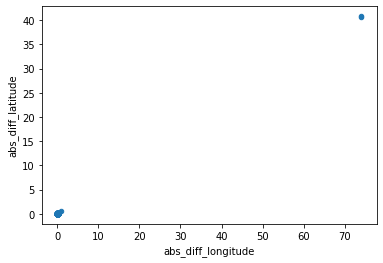

In [105]:
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

In [106]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999931
New size: 9979187


In [107]:
# Construct and return an Nx3 input matrix for our linear model
# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

X_train = get_input_matrix(train_df)
y_train = np.array(train_df['fare_amount'])

print(x_train.shape)
print(y_train.shape)

(44247132, 6)
(9979187,)


In [85]:
# The lstsq function returns several things, and we only care about the actual weight vector w.
(w, _, _, _) = np.linalg.lstsq(X_train, y_train, rcond = None)
print(w)

[147.16176525  76.95503724   6.39545245]


In [86]:
w_OLS = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_train.T, X_train)), X_train.T), y_train)
print(w_OLS)

[147.16176525  76.95503724   6.39545245]


In [108]:
test_df = pd.read_csv(TEST_PATH)
test_df.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [89]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(test_df)
X_test = get_input_matrix(test_df)

# Predict fare_amount on the test set using our model (w) trained on the training set.
y_test_predictions = np.matmul(X_test, w).round(decimals = 2)

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': y_test_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

print(os.listdir('.'))

['.ipynb_checkpoints', '.pytest_cache', 'GCP-Coupons-Instructions.rtf', 'name-of-file.h5', 'new-york-city-taxi-fare-prediction.zip', 'nyc_taxi_data_raw.feather', 'sample_submission.csv', 'submission.csv', 'TaxiFarePrediction.ipynb', 'test.csv', 'train.csv', 'train_h5py']


In [91]:
rmse = np.sqrt(np.mean((y_test_predictions-targets)**2))

print(rmse)

ValueError: operands could not be broadcast together with shapes (11084772,) (9914,) 

In [26]:
train_df_new = pd.read_feather('nyc_taxi_data_raw.feather')

train_df_new.info()

C:\Users\mchow3\AppData\Local\Continuum\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [32]:
%%time

def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df_new)

print('Old size: %d' % len(train_df_new))
train_df_new = train_df_new.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df_new))

print('Old size: %d' % len(train_df_new))
train_df_new = train_df_new[(train_df_new.abs_diff_longitude < 5.0) & (train_df_new.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df_new))

#feature_cols = ['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']
feature_cols = ['abs_diff_longitude', 'abs_diff_latitude', 'passenger_count']

x = train_df_new[feature_cols]

y = train_df_new['fare_amount']

print(x.shape)
print(x.head())
print(y.shape)
print(y.head())

#print(train_df_new.head())

Old size: 55423480
New size: 55423480
Old size: 55423480
New size: 55308916
(55308916, 3)
   abs_diff_longitude  abs_diff_latitude  passenger_count
0            0.002701           0.009041                1
1            0.036774           0.070702                1
2            0.008507           0.010708                2
3            0.004440           0.024948                1
4            0.011436           0.015755                1
(55308916,)
0     4.5
1    16.9
2     5.7
3     7.7
4     5.3
Name: fare_amount, dtype: float32
Wall time: 8.4 s


In [33]:
%%time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(44247132, 3)
(44247132,)
(11061784, 3)
(11061784,)
Wall time: 7.14 s


In [34]:
%%time
# In the following line, "my_linreg" is instantiated as an "object" of LinearRegression "class". 
my_linreg = LinearRegression()

# fitting the model to the training data:
my_linreg.fit(x_train, y_train)

Wall time: 1.45 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
# printing Theta0 using attribute "intercept_":
print("\nIntercept: ")
print(my_linreg.intercept_)

# printing [Theta1, Theta2, Theta3] using attribute "coef_":
print("\nCoef_: ")
print(my_linreg.coef_)

# make predictions on the testing set
y_prediction = my_linreg.predict(x_test)

print("\ny_prediction: ")
print(y_prediction)

# Calculating "Mean Square Error" (MSE):
mse = metrics.mean_squared_error(y_test, y_prediction)

# Using numpy sqrt function to take the square root and calculate "Root Mean Square Error" (RMSE)
rmse = np.sqrt(mse)

print("\nRMSE: ")
print(rmse)


Intercept: 
6.336703

Coef_: 
[1.4627786e+02 7.6414520e+01 5.6549072e-02]

y_prediction: 
[ 9.879013  8.384809  8.954946 ... 23.866524 14.568426 11.79248 ]

RMSE: 
6.746997


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D

#train_generator = datagen.flow(x_train, y_train, batch_size=32)

In [20]:
%%time
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(6, 6)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.add(tf.keras.layers.Flatten())

model.fit(x_train, y_train, epochs=5)

#model.evaluate(x_test, y_test, verbose=2)
               

#EPOCHS = 100
#BS = 32

#model.fit_generator(generator=training_generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None,
#                    validation_data=(x_test, y_test), validation_steps=None, validation_freq=1,
#                    class_weight=None, max_queue_size=10, workers=12, use_multiprocessing=True,
#                    shuffle=True, initial_epoch=100)


#H = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS),
#validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
#epochs=EPOCHS)


#model.evaluate(x_test, y_test, verbose=2)

#model.train_on_batch(x, y, sample_weight=None, class_weight=None, reset_metrics=True)

ValueError: Error when checking input: expected flatten_13_input to have 3 dimensions, but got array with shape (44339084, 6)